# HOW TO: characterize time series so we can segment any given dataset

- This notebook demonstrates that how to segment any given dataset based on the types of workload included in it.
- This notebook also includes examples of different time series types, and how to inteprate the *characteristic scores*.


Call `get_ts()` to convert the input JSON lines and the correponding project names into Pandas.series, meanwhile create a list of Wiki project names.

Then start the work flow:

Part I: `discrete_ft()` is a plotting tool that visualizes the time series in the time and frequency domain. `characterize_ts()` does all the heavy-lifting job to characterize time series, output a list containing scores and type. The next two parts will be analysis (a lot of pandas and matplotlib stuff).

Part II: 

Part III: THE ZOO. Check out different time series types we just identified!

In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import heapq

In [2]:
# Important window definition here!
prediction_length = 48
context_length = 72
day = 24
week = day*7
month = day*30
year = day*365

### Prepare time series

In [3]:
# Get the Time Series as pandas.series and corresponding wiki project name from input JSON lines and .txt records!
def get_ts(data_location,label_location,freq):
    df_ts = pd.read_json(data_location, lines=True)
    num_pt = min(len(df_ts.iloc[1, 1]), 100000)
    print('use first ', num_pt, ' points in a time series')
    num_ts = len(df_ts)

    time_series_wiki = []
    for k in range(num_ts):
        t0 = df_ts.iloc[k, 0]
        data = df_ts.iloc[k, 1][:num_pt]
        index = pd.DatetimeIndex(start=t0, freq=freq, periods=num_pt)
        time_series_wiki.append(pd.Series(data=data, index=index))
        
    with open(label_location) as f:
        wp_list = f.read().splitlines()  
        
    return time_series_wiki, wp_list

In [4]:
label_location = '../../data/wp_full-20180101-20190101_get.txt'    
data_location = '../../data/test_1year.json'
freq = 'H'

time_series_wiki, wp_list = get_ts(data_location,label_location,freq)

use first  8784  points in a time series


# Part I: the tool we use to characterize time series -> segment data

### How it works:
- We characterize time series based on their <b>signature peaks</b> in the frequency spectrum.
- This is done by applying a discrete Fourier tranform on the time series then scanning for peaks.

    - The <b>location</b> of the frequency peak indicates whether it's periodic / trend / random noise, a few examples:

        - Time: seasonality with period T --> Freq: peak at 1/T (and should > the smallest freq to separate it from the zero freq component), half day seasonality peak at 2, day peak at 1, week peak at ~0.143, month peak at ~ 0.033, etc

        - Time: trend or gaussian pulse --> Freq: peak at ~0 with vary fast decay, typically diminishes around ~0.01 in this case

        - Time: constant signal --> Freq: zero frequency component

        - Time: random noise with constant mean --> Freq: random noise

        - Time: delta(x-x0) --> Freq: e^-i2pi(x-x0)k

        - Time: periodic impulse --> Freq: periodic impulse

    - The <b>amplitude</b> of the peak relfects how *strong* this characteristic is.

    - The characteristic score: if it shows such characteristic, it gets a score (normalized amplitude); if not, it gets a 0 score in this category. Note, the <b>characteristic score</b> is normalized both within the frequency spectrum (by divided over # of time points) and across different time series (normalized to N(0,1)).
    
    - Finally, we determine the <b>type</b> of the time series by it's highest characteristic score.
    
### Based on the time series characterization, given the data set, we can examine what's in there:

1. a break-down of different types of time series -- by *type*, I mean the strongest characteristic of given time series: time series can show <b>multiple characteristics</b>, e.g. periodic + trend.
2. We can have detailed look of the score distributions for each type of time series, regardless of what the *type* is.
3. The characteristic score is <b>normalized</b>: this means we can compare within one time series, and we can compare across different time series.
    

### DFT visualization function

In [5]:
# discrete Fourier transform with FFT
def discrete_ft(x,window):
    # important variables are written explicitly
    y = x.values # signal

    Fs = 1 # sampling rate, in our case let's use 1 Hour^-1
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range

    # we only keep the positive frequency up to the Nyquist
    cycle = frq[range(1,int(n/2))] * window # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(1, int(n/2))] # again, spectrum corrresponding to the positive half

    fig, ax = plt.subplots(2, 1, figsize = (10,8))
    ax[0].plot(x)
    ax[0].set_xlabel('Time')
    ax[0].set_ylabel('HTTP request count')
    ax[1].plot(cycle,abs(Y),'r') # plotting the spectrum
    ax[1].set_xlabel('cycles per '+str(window)+' hours')
    ax[1].set_ylabel('Frequency spectrum')

### The time series characterization tool based on discrete Fourier transform.

In [6]:
# time series characterization with FFT
import heapq
def characterize_ts(ts, window):
    y = ts.values  # signal
    Fs = 1  # sampling rate, in our case let's use 1 Hour^-1
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    # We only keep the positive frequency up to the Nyquist = 1/(2*dT), dT = sampling interval.
    cycle = frq[range(1, int(n / 2))] * window  # one side frequency range

    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y = Y[range(1, int(n / 2))]  # again, spectrum corrresponding to the positive half
    yabs = np.abs(Y)

    # Locate the largest 15 peaks, use them to characterise the time series.
    indx = heapq.nlargest(15, range(len(yabs)), yabs.__getitem__)
    amp = heapq.nlargest(15, yabs)

    mean = yabs.mean()
    std = yabs.std()
    cyc_hday = 2.0
    cyc_day = cyc_hday / 2.0
    cyc_week = cyc_day / 7.0
    cyc_month = cyc_day / 30.0

    comp = lambda a, b: np.abs(a / b - 1) < 0.05
    ts_type = ['trend', 'hDay', 'Day', 'Week', 'Month', 'DayImpulse', 'spike']
    report_list = [0] * 8
    for counter, value in enumerate(indx):
        # Here we define a peak in frequency domain.
        if amp[counter] > (mean + 3 * std):
            amp_norm = (amp[counter] - mean) / std
            if cycle[value] < 0.01:
                # Trend (increasing, decreasing, gaussian pulse).
                report_list[0] = max(amp_norm, report_list[0])
            elif comp(cycle[value], cyc_hday):
                report_list[1] = max(amp_norm, report_list[1])
            elif comp(cycle[value], cyc_day):
                report_list[2] = max(amp_norm, report_list[2])
            elif comp(cycle[value], cyc_week):
                report_list[3] = max(amp_norm, report_list[3])
            elif comp(cycle[value], cyc_month):
                report_list[4] = max(amp_norm, report_list[4])

    if sum(report_list[:5]) > 0:
        index = report_list[:5].index(max(report_list[:5]))
        report_list[5] = ts_type[index]
    else:
        report_list[5] = ts_type[-1]

    # Add a subcategory: a special day seasonality that has a periodic impulse shape.
    if report_list[5] == 'hDay' or report_list[5] == 'Day':
        harmonic = set(range(12))
        all_peak = set()
        for counter, value in enumerate(indx):
            if amp[counter] > (mean + 3 * std):
                all_peak.add(int(round(cycle[value])))
        if len(harmonic.intersection(all_peak)) > 10:
            report_list[5] = ts_type[-2]

    report_list[-2] = y.mean()
    report_list[-1] = y.std()
    return report_list

### Convert the characterization report list to Pandas dataframe for easier speculation.

In [7]:
character_list = []
for item in time_series_wiki:
    character_list.append(characterize_ts(item,day))

with open(data_location[:-5] + '_stats.txt', 'w') as f:
    for item in character_list:
        for info in item:
            f.write("%s\t" % info)
        f.write("\n")    

In [8]:
df = pd.DataFrame(character_list,wp_list, 
                  columns = ['trend_score', 'hday_score', 'day_score','week_score', 'month_score','character','mean','std'])

In [9]:
df.reset_index(level=0, inplace=True)
df.rename(columns={'index':'project'}, inplace = True)

In [10]:
# Now we have a workable dataframe
df.head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
0,aa.wikipedia.org,11.418841,0.000000,0.000000,0.0,7.875303,trend,27.925888,95.229821
1,aa.wikibooks.org,13.385391,0.000000,0.000000,0.0,12.325506,trend,20.088342,122.588757
2,aa.wiktionary.org,9.347850,11.925226,11.978428,0.0,0.000000,DayImpulse,5.751138,15.827372
3,ab.wikipedia.org,14.519234,0.000000,10.684804,0.0,0.000000,trend,202.561931,303.248786
4,ab.wiktionary.org,8.253239,15.463952,14.215497,0.0,4.614637,DayImpulse,6.962887,20.878857


# Part II: an overview of the data





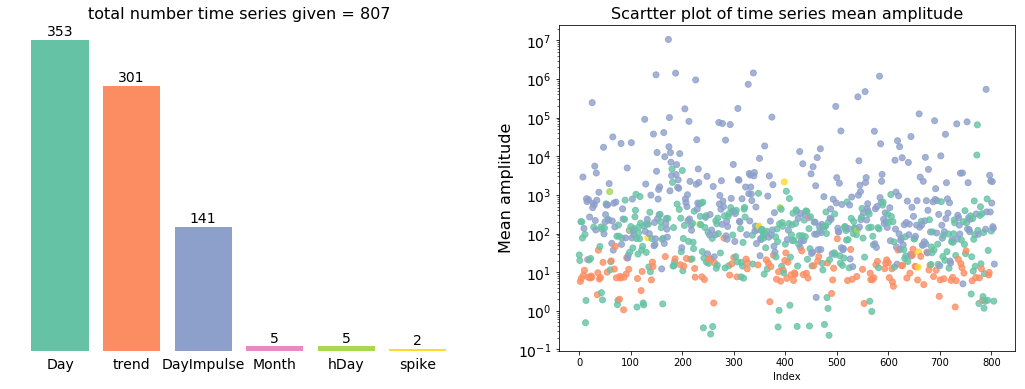

In [11]:
from matplotlib.ticker import FuncFormatter

# Unique category labels: 'day', 'trend', 'hday', ...
color_labels = df['character'].unique()

# List of RGB triplets
rgb_values = sns.color_palette("Set2", len(color_labels))

# Map label to RGB
color_map = dict(zip(color_labels, rgb_values))

# Plot time series buckets breakdown + mean amplitude scatter side by side!
plt.figure(figsize = (18,6))

plt.subplot(1, 2, 1)
bars = plt.bar(df['character'].value_counts().index, 
        height =  df['character'].value_counts(),
        color = color_map.values())
plt.title('total number time series given = {}'.format(len(df)), fontsize = 16)
plt.gca().yaxis.set_major_formatter(FuncFormatter('{0:.0%}'.format)) 
# Remove all the ticks (both axes), and tick labels on the Y axis
plt.tick_params(top=False, bottom=False, left=False, right=False, labelleft=False, labelbottom=True)
plt.gca().tick_params(axis='x', labelsize=14)

# Remove the frame of the chart
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
# Add number of ts in this category on top
for bar in bars:
    plt.gca().text(bar.get_x() + bar.get_width()/2, bar.get_height()+5, str(bar.get_height()), 
                 ha='center', color='k', fontsize=14)

plt.subplot(1, 2, 2)
plt.scatter(df.index, df['mean'], c = df['character'].map(color_map), alpha = 0.8)
plt.gca().set_yscale("log")
plt.gca().tick_params(axis='y', labelsize=14)
plt.title('Scartter plot of time series mean amplitude', fontsize = 16)
plt.ylabel('Mean amplitude', fontsize = 16)
plt.xlabel('Index')
plt.show()

### The three most prodominant characteristic scores are Day-seasonality score, trend score, half-day score. We can further examine their distribution, and whether there's any correlation between any pair of them.

1. The following is a pair-plot for <b>Day-seasonality score</b>, <b>trend score</b>, <b>half-day score</b>, the diagonal components show a kernel density estimation of each component.
2. We can see a loose correlation between <b>Day-seasonality score</b> and <b>half-day score</b>, this is mostly due to a special day-seasonality time series type <b>Day Impulse</b>, in which the frequency spectrum shows periodic impulses at 1,2,3... harmonics.

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


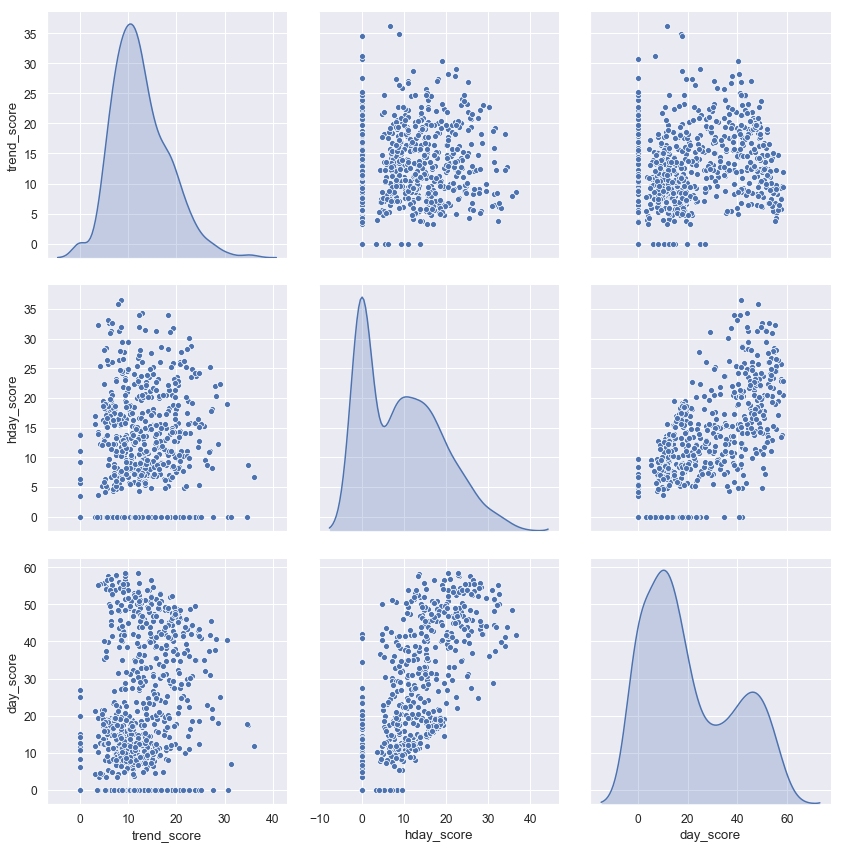

In [12]:
sns.set(font_scale=1.1)
sns.pairplot(df.loc[:, ['trend_score','hday_score','day_score']], diag_kind='kde', height=4);

### Examine scale (mean amplitude) of the time series.
- Note that we have logscale for x-axis. The distribution of the amplitude is skewed, mostly small scale time series with fewer large scale (heavy web traffic) ones. 

mean of mean over all time series..(ugh weird wording)  26702.176045271026  max val  10508012.864184882  min val  0.23258196721311475


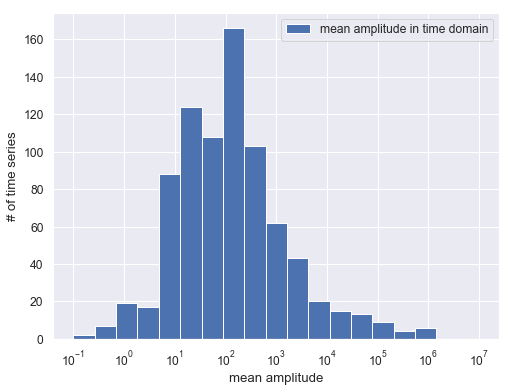

In [13]:
print('mean of mean over all time series..(ugh weird wording) ', 
      df['mean'].mean(), ' max val ', df['mean'].max(), ' min val ', df['mean'].min())
plt.figure(figsize = (8,6))
plt.hist(df['mean'], bins=np.logspace(np.log10(0.1),np.log10(10000000), 20), 
         label = 'mean amplitude in time domain')
plt.gca().set_xscale("log")
plt.xlabel('mean amplitude')
plt.ylabel('# of time series')
plt.legend()
plt.show()

### Examine how the *Day seasonality* characteristic distributes in the dataset.
- Most time series show certain extent of day seasonality.

20.87345900410888


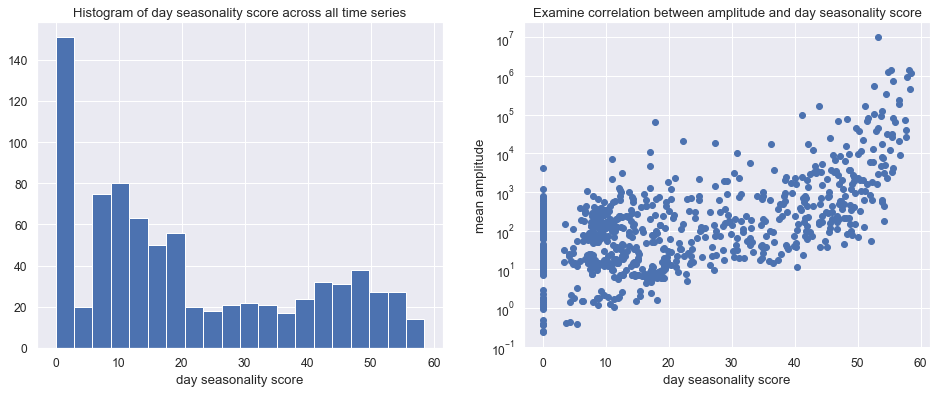

In [14]:
print(df['day_score'].mean())

plt.figure(figsize = (16,6) )
plt.subplot(1, 2, 1)
plt.hist(df['day_score'], bins = 20)
plt.title('Histogram of day seasonality score across all time series')
plt.xlabel('day seasonality score')

plt.subplot(1, 2, 2)
plt.scatter(df['day_score'], df['mean'])
plt.title('Examine correlation between amplitude and day seasonality score')
plt.gca().set_yscale("log")
plt.xlabel('day seasonality score')
plt.ylabel('mean amplitude')
plt.show()

### Examine how the *trend* characteristic distributes in the dataset.

12.632097872475471


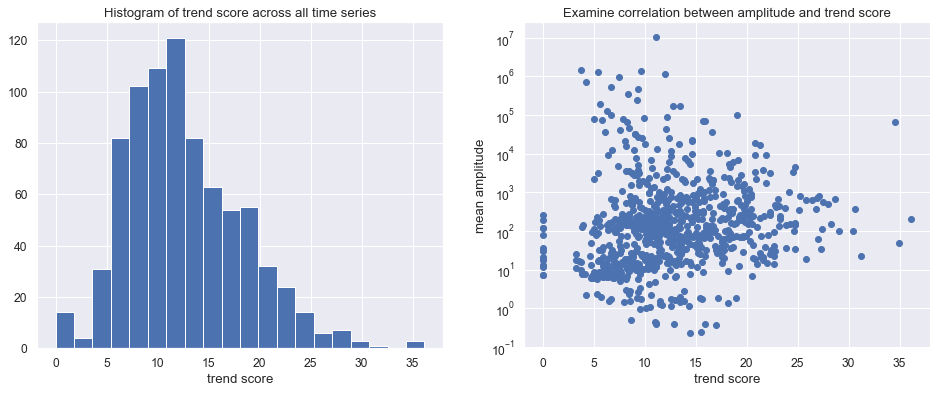

In [15]:
print(df['trend_score'].mean())

plt.figure(figsize = (16,6) )
plt.subplot(1, 2, 1)
plt.hist(df['trend_score'], bins = 20)
plt.title('Histogram of trend score across all time series')
plt.xlabel('trend score')

plt.subplot(1, 2, 2)
plt.scatter(df['trend_score'], df['mean'])
plt.title('Examine correlation between amplitude and trend score')
plt.gca().set_yscale("log")
plt.xlabel('trend score')
plt.ylabel('mean amplitude')
plt.show()

### Examine how the *Half day seasonality* characteristic distributes in the dataset.
- Most of the time series don't have such characteristic.

9.561388292224471


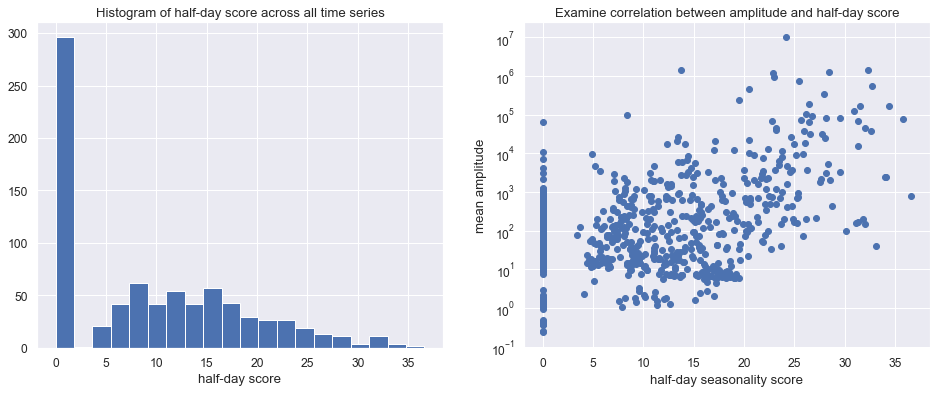

In [16]:
print(df['hday_score'].mean())

plt.figure(figsize = (16,6) )
plt.subplot(1, 2, 1)
plt.hist(df['hday_score'], bins = 20)
plt.title('Histogram of half-day score across all time series')
plt.xlabel('half-day score')

plt.subplot(1, 2, 2)
plt.scatter(df['hday_score'], df['mean'])
plt.title('Examine correlation between amplitude and half-day score')
plt.gca().set_yscale("log")
plt.xlabel('half-day seasonality score')
plt.ylabel('mean amplitude')
plt.show()

### Examine how the *week* characteristic distributes in the dataset.
- Most time series don't show any weekly seasonality. A small portion of them show a bit of this characteristic.

3.2110487819094384


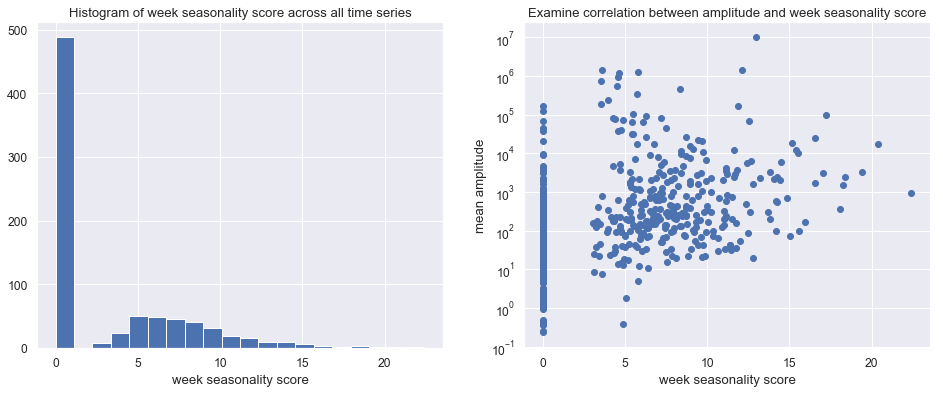

In [17]:
print(df['week_score'].mean())

plt.figure(figsize = (16,6) )
plt.subplot(1, 2, 1)
plt.hist(df['week_score'], bins = 20)
plt.title('Histogram of week seasonality score across all time series')
plt.xlabel('week seasonality score')

plt.subplot(1, 2, 2)
plt.scatter(df['week_score'], df['mean'])
plt.title('Examine correlation between amplitude and week seasonality score')
plt.gca().set_yscale("log")
plt.xlabel('week seasonality score')
plt.ylabel('mean amplitude')
plt.show()

### Examine how the *month* characteristic distributes in the dataset.
- Again, most time series don't show any weekly seasonality. A very small portion of them show a bit of this characteristic.

1.4328699110415941


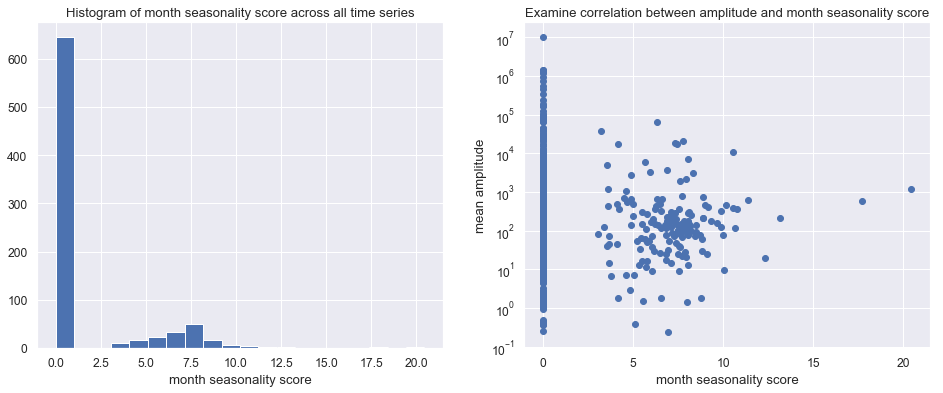

In [18]:
print(df['month_score'].mean())

plt.figure(figsize = (16,6) )
plt.subplot(1, 2, 1)
plt.hist(df['month_score'], bins = 20)
plt.title('Histogram of month seasonality score across all time series')
plt.xlabel('month seasonality score')

plt.subplot(1, 2, 2)
plt.scatter(df['month_score'], df['mean'])
plt.title('Examine correlation between amplitude and month seasonality score')
plt.gca().set_yscale("log")
plt.xlabel('month seasonality score')
plt.ylabel('mean amplitude')
plt.show()

# Part III THE ZOO: examples of different time series types from the input dataset

## *Day* seasonality time series: period = day

In [19]:
# check a few Day seasonality time series
df.loc[df['character'] == 'Day', :].sort_values(by = 'day_score', ascending = False).head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
583,ru.wikipedia.org,12.002549,22.920719,58.522701,4.661875,0.0,Day,1.177687e+06,491780.690852
555,pt.wikipedia.org,9.363315,20.517322,58.304491,8.336847,0.0,Day,4.699367e+05,220754.292696
187,es.wikipedia.org,9.666588,13.734932,58.078266,12.137770,0.0,Day,1.412229e+06,629038.816024
226,fr.wikipedia.org,7.503050,22.948361,57.800319,4.563756,0.0,Day,9.438559e+05,449531.722369
228,fr.wiktionary.org,9.309148,13.478761,57.671281,8.689841,0.0,Day,2.676646e+04,14387.944345


We can see a clear daily-periodic behavior in the following example. We can also see a hint of the weekly periodity and half-day periodity (the small dent on daily peaks). These are also reflected in the week-score and half-day score.

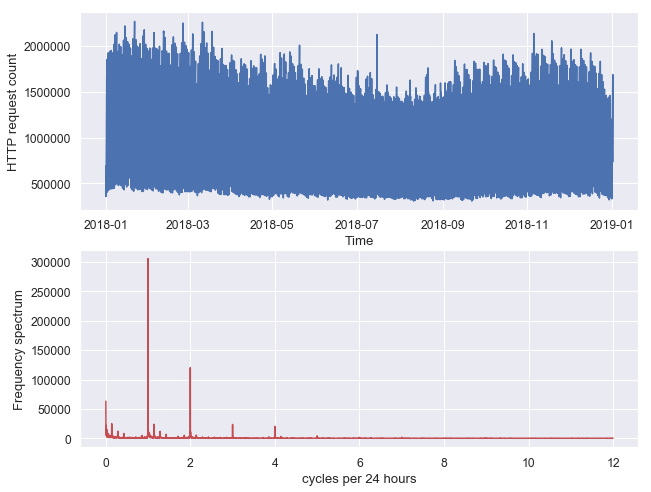

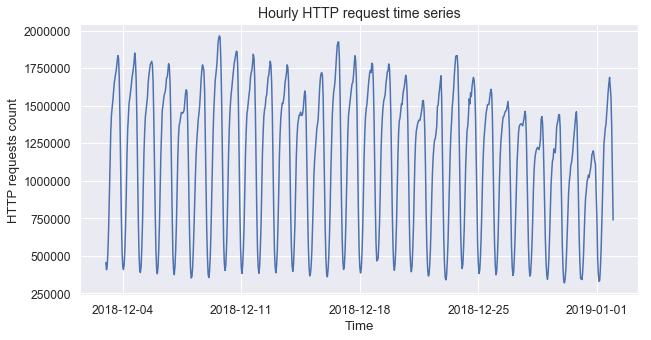

In [20]:
ts = time_series_wiki[583]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-month:])
plt.xlabel('Time')
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.show()

## *Trend* time series: non-periodic time dependence

In [21]:
# check a few Trend time series
df.loc[df['character'] == 'trend', :].sort_values(by = 'trend_score', ascending = False).head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
746,uz.wiktionary.org,36.158317,6.646503,11.745983,0.000000,0.000000,trend,202.448770,175.684755
666,sv.wikiversity.org,34.920641,8.780989,17.403121,7.213818,0.000000,trend,50.443989,43.352579
773,www.wikidata.org,34.574029,0.000000,17.765845,6.123458,6.355391,trend,64895.940574,32640.506107
514,nostalgia.wikipedia.org,31.236253,0.000000,7.099546,0.000000,0.000000,trend,23.196380,54.190756
422,ln.wikipedia.org,30.654178,0.000000,0.000000,0.000000,4.258209,trend,373.752618,730.446066


This example shows trendy behavior (reflected as peak near zero freq component in the frequency spectrum). It also has some day-seasonality but dominant characteristic is trend.

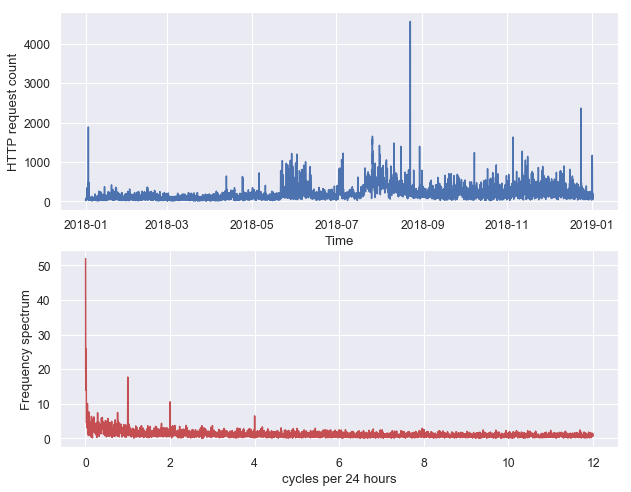

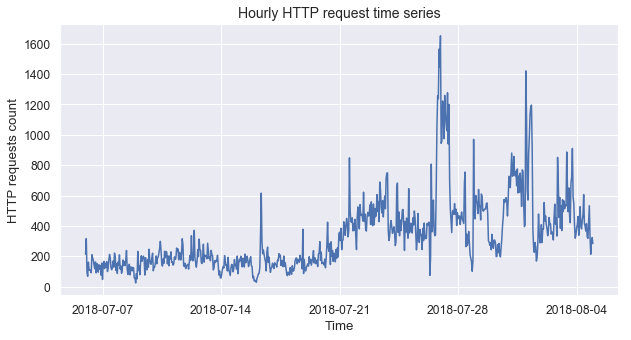

In [22]:
ts = time_series_wiki[746]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-6*month:-5*month])
plt.xlabel('Time')
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.show()

## *Day Impulse*: a special subcategory of day-seasonality that needs to be taken care separately.



### This Day-impulse type of time series are more like periodic daily impulse trains. These time series are not easy to predict with current deepAR model.

In [23]:
# check a few DayImpulse time series
df.loc[df['character'] == 'DayImpulse', :].head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
2,aa.wiktionary.org,9.347850,11.925226,11.978428,0.0,0.000000,DayImpulse,5.751138,15.827372
4,ab.wiktionary.org,8.253239,15.463952,14.215497,0.0,4.614637,DayImpulse,6.962887,20.878857
8,af.wikibooks.org,7.731113,15.861358,17.465511,0.0,0.000000,DayImpulse,8.364185,13.974948
10,af.wikiquote.org,8.900630,13.191388,17.494777,0.0,0.000000,DayImpulse,11.170537,16.165619
17,am.wikiquote.org,5.981971,19.206338,17.578217,0.0,0.000000,DayImpulse,7.442168,19.795553


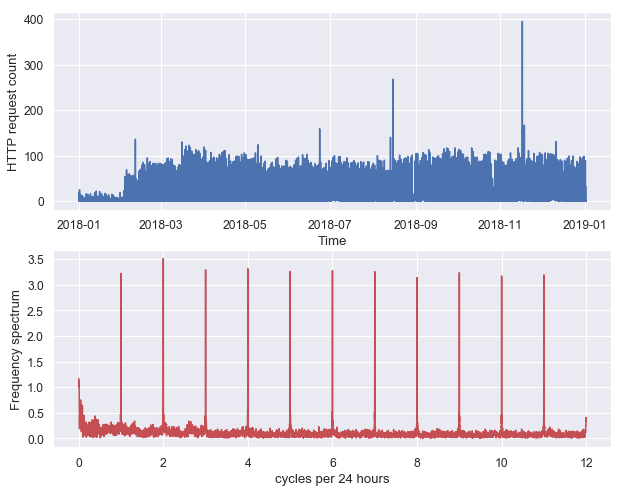

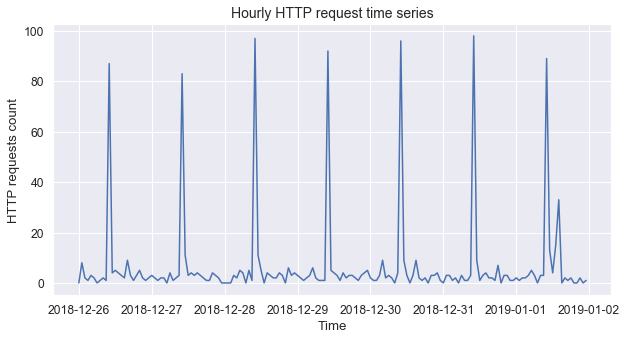

In [24]:
# DayImpulse example
ts = time_series_wiki[17]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-week:])
plt.xlabel('Time')
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.show()

## *Spike*: the time series that doesn't show strong seasonality or trend.
In frequency domain, we won't find any signature peaks.

In [25]:
# check a few spiky time series
df.loc[df['character'] == 'spike', :].head()

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
16,am.wiktionary.org,0.0,0.0,0.0,0.0,0.0,spike,21.171676,311.631902
445,mhr.wikipedia.org,0.0,0.0,0.0,0.0,0.0,spike,255.601434,584.741952


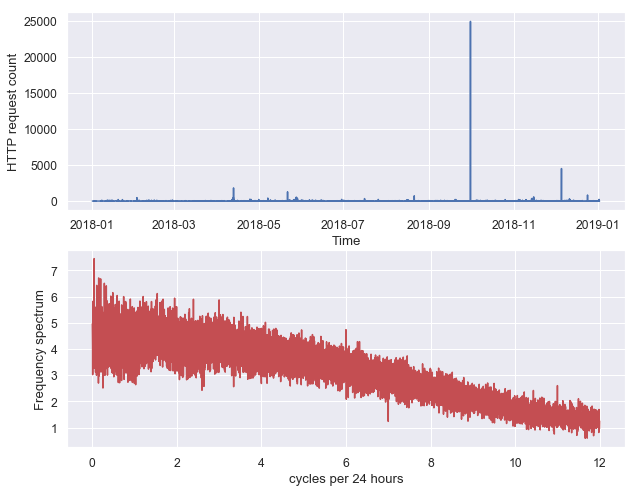

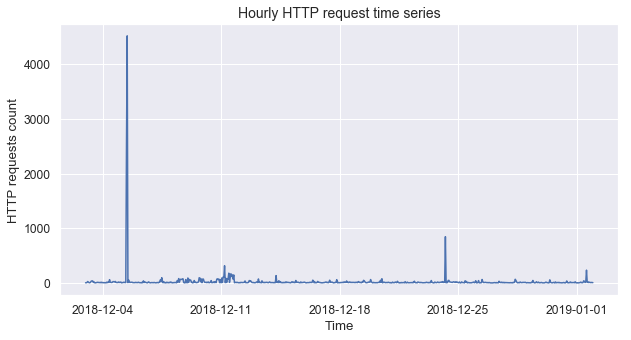

In [26]:
# a spike example: doesn't show any trend or seansonality, no distinctive peaks in freq domain
ts = time_series_wiki[16]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-month:])
plt.xlabel('Time')
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.show()

## Other (rarely occurred) types of seasonalities: month, half-day...

###  *Monthly* seasonality examples:

In [27]:
df.loc[df['character'] == 'Month', :]

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
59,be-tarask.wikipedia.org,12.243367,0.0,0.000000,0.000000,20.443645,Month,1213.344718,1754.792781
99,bug.wikipedia.org,0.000000,0.0,0.000000,0.000000,9.908845,Month,121.811362,434.085662
234,frp.wikipedia.org,7.470163,0.0,6.569571,0.000000,9.344859,Month,172.912227,370.974582
390,ku.wikipedia.org,8.753603,0.0,0.000000,7.726023,8.998203,Month,466.923953,504.471263
540,pih.wikipedia.org,7.080553,0.0,0.000000,6.299424,7.142458,Month,123.088001,430.654332


### The following time series has strong monthly peaks.

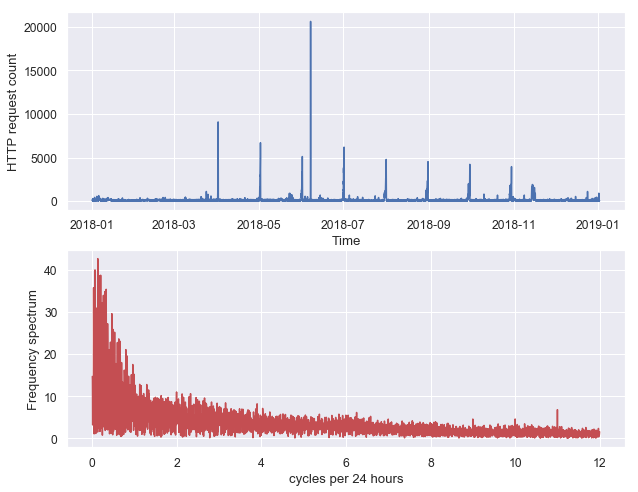

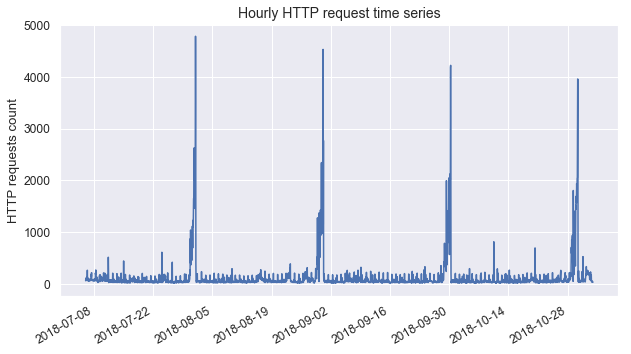

In [28]:
ts = time_series_wiki[99]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-month*6:-month*2])
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.setp(plt.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

### *Half-day* seasonality examples:

In [29]:
df.loc[df['character'] == 'hDay', :]

,project,trend_score,hday_score,day_score,week_score,month_score,character,mean,std
133,cs.wikiversity.org,0.000000,3.464595,0.000000,0.000000,0.000000,hDay,77.926002,303.116718
349,jv.wiktionary.org,18.807626,31.124540,28.912659,11.736760,0.000000,hDay,155.181011,159.414141
398,ky.wikipedia.org,20.926311,27.685592,24.822586,14.083401,7.961447,hDay,2168.339936,1812.231530
658,su.wiktionary.org,0.000000,9.287476,8.218113,0.000000,0.000000,hDay,13.387181,40.292451
659,su.wikiquote.org,13.754216,22.694101,21.975108,9.005471,0.000000,hDay,33.342896,41.184764


### The following time series shows both half-day and day seasonality, but the half-day characteristic is stronger.

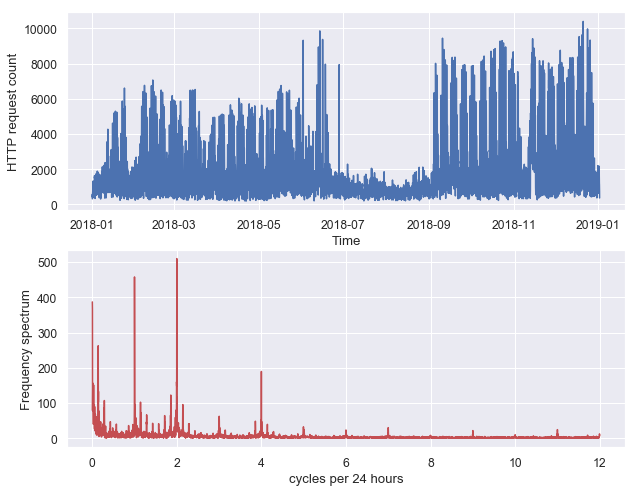

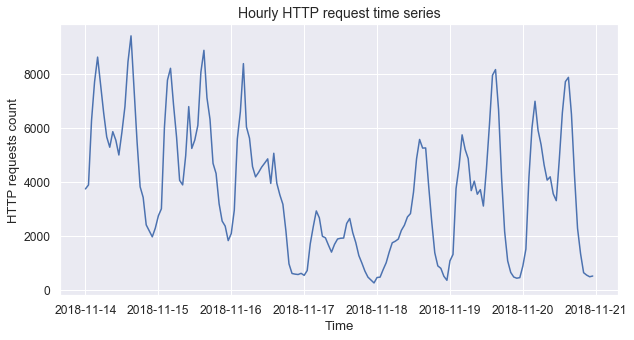

In [30]:
ts = time_series_wiki[398]
discrete_ft(ts,day)
plt.figure(figsize = (10,5))
plt.plot(ts[-7*week:-6*week])
plt.xlabel('Time')
plt.ylabel('HTTP requests count')
plt.title('Hourly HTTP request time series',fontsize = 14)
plt.show()